# Introdução à Validação de Modelos

Este notebook apresenta os conceitos fundamentais de validação de modelos de machine learning.


In [1]:
# Imports básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.tree import DecisionTreeClassifier

# Configuração de plotting
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (10, 6)

## Objetivos da Aula

- Entender a importância da validação
- Conceitos de overfitting e underfitting
- Train, validation, test splits
- Holdout validation


In [2]:
# Configurar seed para reprodutibilidade
np.random.seed(42)

print("✅ Ambiente configurado com sucesso!")
print("Versões das bibliotecas:")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")

✅ Ambiente configurado com sucesso!
Versões das bibliotecas:
NumPy: 1.26.4
Pandas: 2.3.1


## 1. O que é Validação de Modelos?

A **validação de modelos** é um processo fundamental no machine learning que visa avaliar quão bem um modelo consegue generalizar para dados não vistos durante o treinamento.

### Definição Formal

Dado um modelo $f$ treinado em um conjunto de dados $\mathcal{D}_{train}$, a validação busca estimar a performance do modelo em dados futuros através da avaliação em conjuntos de dados independentes.

### Por que Validar?

1. **Avaliar Generalização**: Um modelo pode memorizar os dados de treino mas falhar em dados novos
2. **Detectar Problemas**: Identificar overfitting, underfitting e outros issues
3. **Comparar Modelos**: Escolher o melhor algoritmo/configuração
4. **Estimar Performance Real**: Ter expectativas realistas sobre o desempenho em produção

### O Problema Fundamental

> **"Um modelo que funciona perfeitamente nos dados de treino pode ser completamente inútil em dados reais"**

Isso acontece porque o modelo pode simplesmente "decorar" os dados ao invés de aprender padrões generalizáveis.


Acurácia nos dados de TREINO:
Modelo 'decoreba' (K=1): 1.000
Modelo balanceado: 1.000

🤔 Qual modelo é melhor? Precisamos de dados de teste para saber!


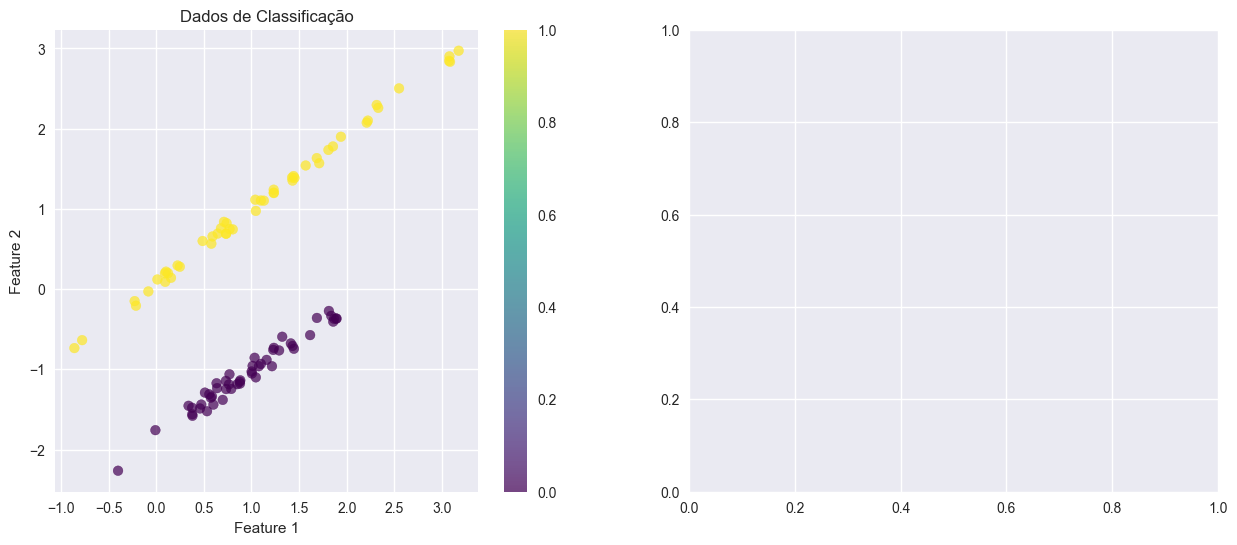

In [ ]:
# Exemplo ilustrativo: O problema da "decoreba"
# Vamos criar um modelo que "decora" vs um que generaliza

# Gerando dados sintéticos
X, y = make_classification(
    n_samples=100, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, random_state=42
)

# Visualizando os dados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Dados originais
scatter = ax1.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", alpha=0.7)
ax1.set_title("Dados de Classificação")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
plt.colorbar(scatter, ax=ax1)

# Simulando overfitting: modelo muito complexo
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Modelo que "decora" (overfit)
overfit_model = KNeighborsClassifier(n_neighbors=1)
overfit_model.fit(X, y)

# Modelo que generaliza melhor
balanced_model = DecisionTreeClassifier(max_depth=3, random_state=42)
balanced_model.fit(X, y)

# Performance nos dados de treino
train_acc_overfit = overfit_model.score(X, y)
train_acc_balanced = balanced_model.score(X, y)

print(f"Acurácia nos dados de TREINO:")
print(f"Modelo 'decoreba' (K=1): {train_acc_overfit:.3f}")
print(f"Modelo balanceado: {train_acc_balanced:.3f}")
print("\n🤔 Qual modelo é melhor? Precisamos de dados de teste para saber!")

## 2. Overfitting vs Underfitting

### 2.1 Definições

**Overfitting (Sobreajuste)**

- O modelo memoriza os dados de treino ao invés de aprender padrões
- Alta performance em treino, baixa performance em teste
- Modelo muito complexo para os dados disponíveis

**Underfitting (Subajuste)**

- O modelo é muito simples para capturar padrões nos dados
- Baixa performance tanto em treino quanto em teste
- Modelo não aprende adequadamente

**Sweet Spot (Ponto Ótimo)**

- Equilíbrio entre complexidade e generalização
- Boa performance tanto em treino quanto em teste

### 2.2 A Relação Bias-Variance

- **Bias alto**: Underfitting - modelo muito simples
- **Variance alta**: Overfitting - modelo muito complexo
- **Objetivo**: Minimizar ambos (bias-variance tradeoff)


In [ ]:
# Demonstração prática: Overfitting vs Underfitting
# Vamos usar polinômios de diferentes graus para mostrar o conceito

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Criar dados com ruído para regressão
np.random.seed(42)
n_samples = 50
X_simple = np.linspace(0, 1, n_samples).reshape(-1, 1)
y_simple = 1.5 * X_simple.ravel() + 0.5 * np.sin(15 * X_simple.ravel()) + np.random.normal(0, 0.1, n_samples)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_simple, y_simple, test_size=0.3, random_state=42)

# Testar diferentes graus de polinômios
degrees = [1, 3, 8, 15]
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

results = []

for i, degree in enumerate(degrees):
    # Criar pipeline com polinômio
    poly_model = Pipeline([("poly", PolynomialFeatures(degree=degree)), ("linear", LinearRegression())])

    # Treinar modelo
    poly_model.fit(X_train, y_train)

    # Predições
    y_train_pred = poly_model.predict(X_train)
    y_test_pred = poly_model.predict(X_test)

    # Calcular erros
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    results.append({"degree": degree, "train_mse": train_mse, "test_mse": test_mse})

    # Plot
    X_plot = np.linspace(0, 1, 100).reshape(-1, 1)
    y_plot = poly_model.predict(X_plot)

    axes[i].scatter(X_train, y_train, alpha=0.6, label="Treino", color="blue")
    axes[i].scatter(X_test, y_test, alpha=0.6, label="Teste", color="red")
    axes[i].plot(X_plot, y_plot, color="green", linewidth=2, label=f"Polinômio grau {degree}")
    axes[i].set_title(f"Grau {degree}\nTreino MSE: {train_mse:.3f}, Teste MSE: {test_mse:.3f}")
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Resumo dos resultados
results_df = pd.DataFrame(results)
print("\n📊 Resumo dos Resultados:")
print(results_df)
print("\n🔍 Observações:")
print("- Grau 1: Underfitting (erro alto em ambos)")
print("- Grau 3: Boa generalização")
print("- Grau 8+: Overfitting (erro baixo no treino, alto no teste)")

## 3. Divisão de Dados: Train, Validation, Test

### 3.1 A Importância da Divisão Correta

Para validar modelos adequadamente, precisamos dividir nossos dados em conjuntos distintos:

**🏋️ Conjunto de Treino (Training Set) - 60-70%**

- Usado para treinar o modelo
- O modelo "vê" e aprende com estes dados

**🔧 Conjunto de Validação (Validation Set) - 15-20%**

- Usado para ajustar hiperparâmetros
- Avaliar diferentes configurações do modelo
- Seleção de modelo

**🧪 Conjunto de Teste (Test Set) - 15-20%**

- Avaliação final do modelo
- **NUNCA** usado durante desenvolvimento
- Estimativa imparcial da performance real

### 3.2 Regra de Ouro

> **"O conjunto de teste deve ser uma caixa preta até o final do projeto"**

### 3.3 Estratégias de Divisão

1. **Holdout Simples**: Uma divisão fixa
2. **Holdout Estratificado**: Mantém proporção das classes
3. **Temporal**: Para dados de séries temporais
4. **Por Grupos**: Para dados agrupados (pacientes, usuários, etc.)


In [ ]:
# Exemplo prático: Divisão de dados
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Carregar dados
iris = load_iris()
X, y = iris.data, iris.target

print("📊 Dataset Iris:")
print(f"- Total de amostras: {len(X)}")
print(f"- Features: {X.shape[1]}")
print(f"- Classes: {len(np.unique(y))}")
print(f"- Distribuição das classes: {np.bincount(y)}")

# Método 1: Divisão simples em 3 conjuntos
print("\n🔄 Método 1: Divisão tripla direta")

# Primeiro split: separar conjunto de teste (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Segundo split: dividir restante em treino (64%) e validação (16%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

print(f"Treino: {len(X_train)} amostras ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validação: {len(X_val)} amostras ({len(X_val)/len(X)*100:.1f}%)")
print(f"Teste: {len(X_test)} amostras ({len(X_test)/len(X)*100:.1f}%)")

# Verificar distribuição das classes
print(f"\nDistribuição das classes:")
print(f"Treino: {np.bincount(y_train)}")
print(f"Validação: {np.bincount(y_val)}")
print(f"Teste: {np.bincount(y_test)}")

# Método 2: Usando proporções customizadas
print("\n🔄 Método 2: Divisão com proporções customizadas")


def train_val_test_split(X, y, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    """
    Divide dados em treino, validação e teste com proporções customizadas
    """
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Proporções devem somar 1"

    # Primeiro: separar teste
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    # Segundo: dividir restante entre treino e validação
    val_prop = val_size / (train_size + val_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_prop, random_state=random_state, stratify=y_temp
    )

    return X_train, X_val, X_test, y_train, y_val, y_test


# Aplicar divisão customizada
X_train2, X_val2, X_test2, y_train2, y_val2, y_test2 = train_val_test_split(
    X, y, train_size=0.7, val_size=0.15, test_size=0.15
)

print(f"Treino: {len(X_train2)} amostras ({len(X_train2)/len(X)*100:.1f}%)")
print(f"Validação: {len(X_val2)} amostras ({len(X_val2)/len(X)*100:.1f}%)")
print(f"Teste: {len(X_test2)} amostras ({len(X_test2)/len(X)*100:.1f}%)")

# Visualizar as divisões
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Distribuição por conjunto
sets = ["Treino", "Validação", "Teste"]
sizes1 = [len(X_train), len(X_val), len(X_test)]
colors = ["skyblue", "lightgreen", "lightcoral"]

ax1.pie(sizes1, labels=sets, autopct="%1.1f%%", colors=colors, startangle=90)
ax1.set_title("Divisão dos Dados (Método 1)")

# Gráfico 2: Distribuição das classes por conjunto
width = 0.25
x = np.arange(3)  # 3 classes

for i, (set_name, y_set) in enumerate([("Treino", y_train), ("Validação", y_val), ("Teste", y_test)]):
    counts = np.bincount(y_set)
    ax2.bar(x + i * width, counts, width, label=set_name, color=colors[i], alpha=0.7)

ax2.set_xlabel("Classes")
ax2.set_ylabel("Número de Amostras")
ax2.set_title("Distribuição das Classes por Conjunto")
ax2.set_xticks(x + width)
ax2.set_xticklabels(["Setosa", "Versicolor", "Virginica"])
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Divisão realizada com sucesso!")
print("💡 Dica: Sempre use stratify=y para manter proporção das classes")

## 4. Holdout Validation

### 4.1 O que é Holdout Validation?

**Holdout validation** é a técnica mais simples de validação, onde:

1. Dividimos os dados uma única vez em conjuntos de treino e validação
2. Treinamos o modelo no conjunto de treino
3. Avaliamos no conjunto de validação
4. Repetimos o processo com diferentes hiperparâmetros
5. Escolhemos a configuração com melhor performance na validação

### 4.2 Vantagens e Desvantagens

**✅ Vantagens:**

- Simples de implementar
- Rápida execução
- Fácil de entender

**❌ Desvantagens:**

- Dependente da divisão específica dos dados
- Pode ser instável com datasets pequenos
- Não aproveita todos os dados para treino

### 4.3 Quando usar?

- Datasets grandes (>10.000 amostras)
- Prototipagem rápida
- Recursos computacionais limitados


In [ ]:
# Exemplo completo: Holdout Validation para seleção de hiperparâmetros
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import make_classification

# Gerar dataset sintético mais complexo
X, y = make_classification(
    n_samples=1000, n_features=20, n_informative=15, n_redundant=5, n_classes=3, random_state=42
)

print("📊 Dataset gerado:")
print(f"- Amostras: {X.shape[0]}")
print(f"- Features: {X.shape[1]}")
print(f"- Classes: {len(np.unique(y))}")

# Dividir dados
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"\nDivisão dos dados:")
print(f"- Treino: {len(X_train)} amostras")
print(f"- Validação: {len(X_val)} amostras")
print(f"- Teste: {len(X_test)} amostras")

# Holdout validation para diferentes hiperparâmetros
print("\n🔍 Holdout Validation - Testando diferentes configurações:")

# Hiperparâmetros para testar
n_estimators_list = [10, 50, 100, 200]
max_depth_list = [3, 5, 10, None]

results = []

for n_est in n_estimators_list:
    for max_d in max_depth_list:
        # Treinar modelo
        rf = RandomForestClassifier(n_estimators=n_est, max_depth=max_d, random_state=42)
        rf.fit(X_train, y_train)

        # Avaliar em treino e validação
        train_acc = rf.score(X_train, y_train)
        val_acc = rf.score(X_val, y_val)

        results.append(
            {
                "n_estimators": n_est,
                "max_depth": max_d,
                "train_accuracy": train_acc,
                "val_accuracy": val_acc,
                "overfitting": train_acc - val_acc,
            }
        )

# Converter para DataFrame para análise
results_df = pd.DataFrame(results)

# Encontrar melhor configuração
best_config = results_df.loc[results_df["val_accuracy"].idxmax()]

print(f"\n🏆 Melhor configuração encontrada:")
print(f"- n_estimators: {best_config['n_estimators']}")
print(f"- max_depth: {best_config['max_depth']}")
print(f"- Acurácia validação: {best_config['val_accuracy']:.3f}")
print(f"- Overfitting: {best_config['overfitting']:.3f}")

# Treinar modelo final com melhor configuração
final_model = RandomForestClassifier(
    n_estimators=int(best_config["n_estimators"]),
    max_depth=best_config["max_depth"] if best_config["max_depth"] != "None" else None,
    random_state=42,
)
final_model.fit(X_train, y_train)

# Avaliação final no conjunto de teste
test_acc = final_model.score(X_test, y_test)
print(f"\n🧪 Performance final no teste: {test_acc:.3f}")

# Visualizar resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Heatmap das acurácias de validação
pivot_table = results_df.pivot(index="max_depth", columns="n_estimators", values="val_accuracy")
import seaborn as sns

sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="viridis", ax=ax1)
ax1.set_title("Acurácia de Validação\n(Holdout Validation)")
ax1.set_xlabel("Número de Estimadores")
ax1.set_ylabel("Profundidade Máxima")

# Gráfico 2: Treino vs Validação (top 10 configurações)
top_10 = results_df.nlargest(10, "val_accuracy")
x_pos = range(len(top_10))

ax2.bar([x - 0.2 for x in x_pos], top_10["train_accuracy"], width=0.4, label="Treino", alpha=0.7, color="skyblue")
ax2.bar([x + 0.2 for x in x_pos], top_10["val_accuracy"], width=0.4, label="Validação", alpha=0.7, color="lightcoral")

ax2.set_xlabel("Configurações (Top 10)")
ax2.set_ylabel("Acurácia")
ax2.set_title("Treino vs Validação\n(Melhores Configurações)")
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

print(f"\n📈 Análise dos resultados:")
print(f"- Maior acurácia de validação: {results_df['val_accuracy'].max():.3f}")
print(f"- Menor acurácia de validação: {results_df['val_accuracy'].min():.3f}")
print(f"- Diferença: {results_df['val_accuracy'].max() - results_df['val_accuracy'].min():.3f}")
print(f"- Overfitting médio: {results_df['overfitting'].mean():.3f}")

# Exibir tabela com resultados resumidos
print(f"\n📋 Top 5 configurações:")
print(results_df.nlargest(5, "val_accuracy")[["n_estimators", "max_depth", "val_accuracy", "overfitting"]])

## 5. Validation Curves

### 5.1 O que são Validation Curves?

**Validation curves** são gráficos que mostram como a performance do modelo (em treino e validação) varia conforme mudamos um hiperparâmetro específico.

### 5.2 Utilidade das Validation Curves

- **Visualizar overfitting/underfitting**: Identificar quando o modelo está muito complexo ou simples
- **Escolher hiperparâmetros**: Encontrar valores ótimos graficamente
- **Entender comportamento**: Como cada parâmetro afeta o modelo
- **Detectar problemas**: Instabilidade, plateaus, etc.

### 5.3 Interpretação

- **Gap entre treino e validação**: Indica overfitting
- **Ambas baixas**: Indica underfitting
- **Convergência**: Ponto ótimo de complexidade


In [ ]:
# Validation Curves com sklearn
from sklearn.model_selection import validation_curve

# Usar o mesmo dataset do exemplo anterior
print("🔍 Gerando Validation Curves...")

# Validation curve para max_depth (Decision Tree)
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

train_scores, val_scores = validation_curve(
    DecisionTreeClassifier(random_state=42),
    X_train,
    y_train,
    param_name="max_depth",
    param_range=param_range,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)

# Calcular estatísticas
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Validation curve para Decision Tree
ax1.plot(param_range, train_mean, "o-", color="blue", label="Treino")
ax1.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")

ax1.plot(param_range, val_mean, "o-", color="red", label="Validação")
ax1.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.1, color="red")

ax1.set_xlabel("Max Depth")
ax1.set_ylabel("Acurácia")
ax1.set_title("Validation Curve - Decision Tree")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Encontrar melhor parâmetro
best_depth_idx = np.argmax(val_mean)
best_depth = param_range[best_depth_idx]
ax1.axvline(x=best_depth, color="green", linestyle="--", alpha=0.7, label=f"Ótimo: {best_depth}")
ax1.legend()

print(f"Melhor max_depth para Decision Tree: {best_depth}")
print(f"Acurácia de validação: {val_mean[best_depth_idx]:.3f} ± {val_std[best_depth_idx]:.3f}")

# Validation curve para Random Forest (n_estimators)
param_range_rf = [10, 25, 50, 75, 100, 150, 200]

train_scores_rf, val_scores_rf = validation_curve(
    RandomForestClassifier(random_state=42),
    X_train,
    y_train,
    param_name="n_estimators",
    param_range=param_range_rf,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)

train_mean_rf = np.mean(train_scores_rf, axis=1)
train_std_rf = np.std(train_scores_rf, axis=1)
val_mean_rf = np.mean(val_scores_rf, axis=1)
val_std_rf = np.std(val_scores_rf, axis=1)

ax2.plot(param_range_rf, train_mean_rf, "o-", color="blue", label="Treino")
ax2.fill_between(param_range_rf, train_mean_rf - train_std_rf, train_mean_rf + train_std_rf, alpha=0.1, color="blue")

ax2.plot(param_range_rf, val_mean_rf, "o-", color="red", label="Validação")
ax2.fill_between(param_range_rf, val_mean_rf - val_std_rf, val_mean_rf + val_std_rf, alpha=0.1, color="red")

ax2.set_xlabel("N Estimators")
ax2.set_ylabel("Acurácia")
ax2.set_title("Validation Curve - Random Forest")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Encontrar melhor parâmetro para RF
best_n_est_idx = np.argmax(val_mean_rf)
best_n_est = param_range_rf[best_n_est_idx]
ax2.axvline(x=best_n_est, color="green", linestyle="--", alpha=0.7, label=f"Ótimo: {best_n_est}")
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\nMelhor n_estimators para Random Forest: {best_n_est}")
print(f"Acurácia de validação: {val_mean_rf[best_n_est_idx]:.3f} ± {val_std_rf[best_n_est_idx]:.3f}")

# Análise dos resultados
print(f"\n📊 Análise das Validation Curves:")
print(f"\nDecision Tree:")
print(f"- Underfitting (max_depth=1): {val_mean[0]:.3f}")
print(f"- Sweet spot (max_depth={best_depth}): {val_mean[best_depth_idx]:.3f}")
print(f"- Overfitting (max_depth=10): {val_mean[-1]:.3f}")
print(f"- Gap treino-validação em max_depth=10: {train_mean[-1] - val_mean[-1]:.3f}")

print(f"\nRandom Forest:")
print(f"- Performance melhora até ~{best_n_est} estimadores")
print(f"- Após isso, platô ou leve degradação")
print(f"- Menor overfitting que Decision Tree única")